In [1]:
from preprocessing import (
    preprocess_kjv,
)
from ontology_algorithm import (
    draw_hierarchy_tree_from_ontology,
)
from integrative_worklow import (
    construct_topic_modeling_concept_hierarchy,
)

## Preprocessing

We will preprocess words from the theology reconsidered text using tf-idf and extract the top n words.

In [2]:
kjv_path = "/Users/zebo/Documents/Freelancing/upwork/Peter_J_Worth_Jr/NLP/hierarchical_clustering/data/t_kjv.csv"
kjv_bible_df = preprocess_kjv(
    path_to_kjv=kjv_path,
)

# Get book column unique values.
all_books = kjv_bible_df["book"].unique()

# Specify the number of top words to use.
n = 70

books = []
for book in all_books:
    book_df = kjv_bible_df[kjv_bible_df["book"] == book]
    book_text = ""
    for chapter in book_df["chapter"].unique():
        chapter_df = book_df[book_df["chapter"] == chapter]
        book_text += " ".join(chapter_df["text"].values)
    books.append(" ".join(chapter_df["text"].values))

sentences_per_book = []
for book in all_books:
    book_sentences = []
    book_df = kjv_bible_df[kjv_bible_df["book"] == book]
    for chapter in book_df["chapter"].unique():
        chapter_df = book_df[book_df["chapter"] == chapter]
        book_sentences.append(" ".join(chapter_df["text"].values))
    sentences_per_book.append(book_sentences)

sentences_per_chapter = sentences_per_book
titles = all_books
chapters = books

## Contruct the ontology tree using the integrative workflow

CLUSTER #1
Cluster Chapters: [1, 2, 18, 19, 20, 21, 26, 27, 28, 30, 31, 32, 33, 34, 35, 58, 65]
Key Features: ['shall', 'thy', 'thou', 'lord', 'thee', 'praise', 'upon', 'unto', 'let', 'shalt', 'ye', 'god', 'day', 'thine', 'estimation', 'thou shalt', 'earth', 'man', 'fruit', 'tabernacle']
CLUSTER #2
Cluster Chapters: [0, 3, 4, 5, 6, 7, 8, 9, 12, 14, 17, 24, 25, 61]
Key Features: ['unto', 'israel', 'lord', 'said', 'inheritance', 'sons', 'god', 'thousand', 'joseph', 'land', 'thee', 'children', 'tribe', 'job', 'david', 'son', 'side', 'people', 'saul', 'us']
CLUSTER #3
Cluster Chapters: [22, 29, 36, 37, 38, 42]
Key Features: ['shall', 'saith', 'saith lord', 'lord', 'hosts', 'lord hosts', 'day', 'ye', 'saith unto', 'unto', 'come', 'earth', 'shall come', 'upon', 'peter', 'jerusalem', 'forth', 'simon', 'jesus', 'nations']
CLUSTER #4
Cluster Chapters: [39, 40, 41, 43, 60]
Key Features: ['unto', 'sepulchre', 'came', 'said', 'ye', 'shall', 'things', 'said unto', 'disciples', 'jesus', 'risen', 'ma

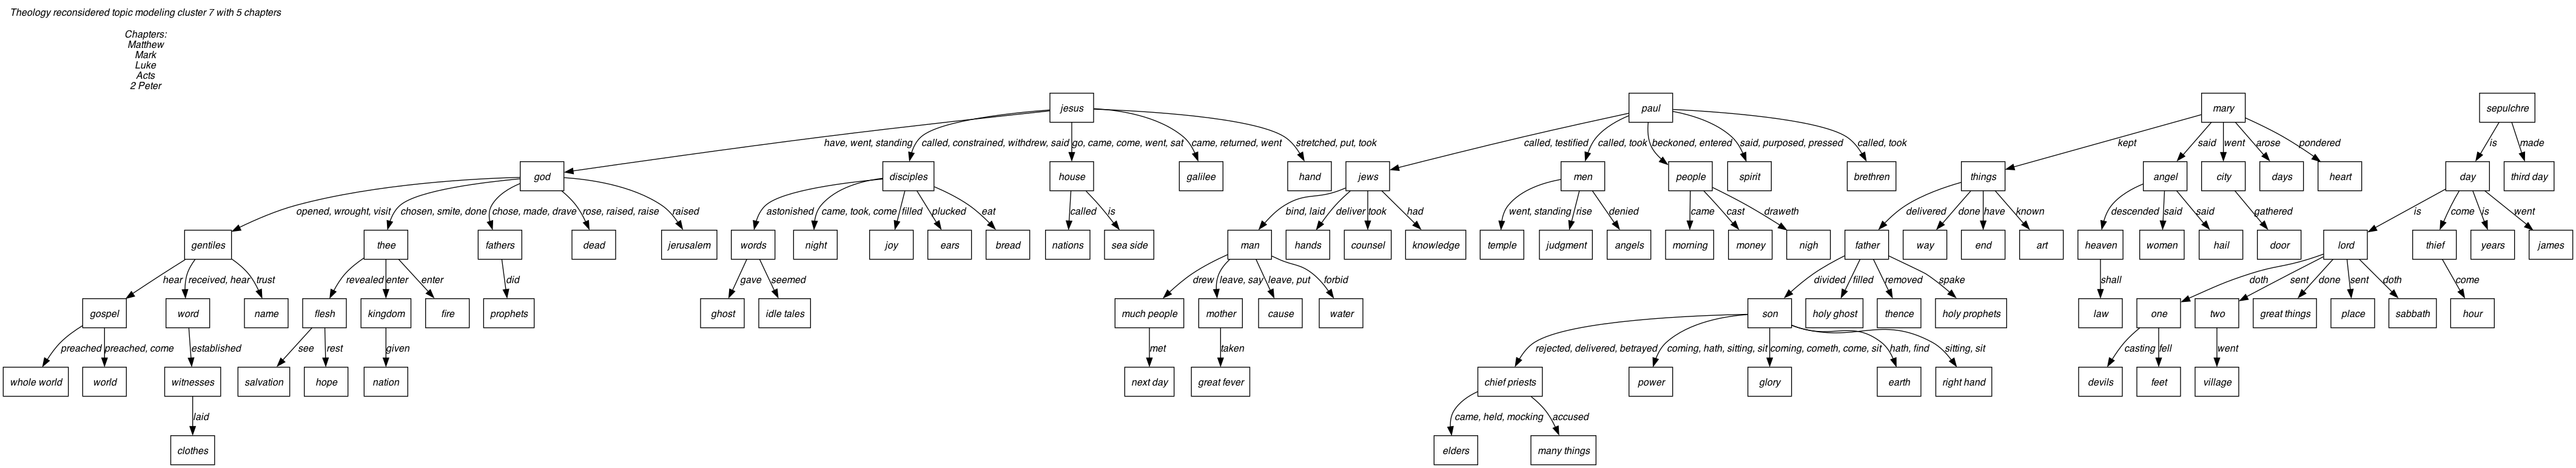

In [3]:
(
    ontology_hierarchy,
    all_relations_to_verbs,
    chapter_titles,
) = construct_topic_modeling_concept_hierarchy(
    chapters=chapters,
    titles=titles,
    sentences_per_chapter=sentences_per_chapter,
    num_topics=6,
    chosen_cluster=4,
    hierarchy_depth=5,
    hierarchy_max_width=5,
    n_key_terms=20,
    manually_added_roots=None,
    verbose=True,
)
# Draw the ontology hierarchy.
draw_hierarchy_tree_from_ontology(
    ontological_hierarchy=ontology_hierarchy,
    relations_to_verbs=all_relations_to_verbs,
    title="Theology reconsidered topic modeling cluster "
    + str(7)
    + " with "
    + str(len(chapter_titles))
    + " chapters",
    topic_modelling_chapters=chapter_titles,
)